Copia versión 121 modificando el número de neuronas de las capas conv2d

In [1]:
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import pandas as pd

%matplotlib inline

Using TensorFlow backend.
/home/isua/anaconda3/envs/CAPRI/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/isua/anaconda3/envs/CAPRI/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/isua/anaconda3/envs/CAPRI/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/isua/anaconda3/envs/CAP

# Carga de datos

In [2]:
X_train_names_0 = os.listdir('datasets/kfold0/train/0_non_consolidation/')
X_train_names_1 = os.listdir('datasets/kfold0/train/1_consolidation/')
X_test_names_0 = os.listdir('datasets/kfold0/test/0_non_consolidation/')
X_test_names_1 = os.listdir('datasets/kfold0/test/1_consolidation/')

In [3]:
from PIL import Image

def my_load_img(f):
    img = Image.open(f)
    fp = img.fp
    img.load()
    fp.closed
    return img

In [4]:
X_train_0 = []
for i in X_train_names_0:
    image = my_load_img('datasets/kfold0/train/0_non_consolidation/'+i)
    X_train_0.append(image)

    
X_train_1 = []
for i in X_train_names_1:
    image = my_load_img('datasets/kfold0/train/1_consolidation/'+i)
    X_train_1.append(image)
    
    
X_test_0 = []
for i in X_test_names_0:
    image = my_load_img('datasets/kfold0/test/0_non_consolidation/'+i)
    X_test_0.append(image)
    
    
X_test_1 = []
for i in X_test_names_1:
    image = my_load_img('datasets/kfold0/test/1_consolidation/'+i)
    X_test_1.append(image)

In [5]:
total_images = len(X_train_0)+len(X_train_1)+len(X_test_0)+len(X_test_1)

In [6]:
if total_images == 950:
    print('okey')
else:
    print('error')

okey


In [7]:
y_train_0 = [0] * len(X_train_0)
y_train_1 = [1] * len(X_train_1)

y_test_0 = [0] * len(X_test_0)
y_test_1 = [1] * len(X_test_1)

y_train = y_train_0 + y_train_1
y_test= y_test_0 + y_test_1

In [8]:
X_train = X_train_0 + X_train_1
X_test = X_test_0 + X_test_1

In [9]:
print(len(X_train))
print(len(X_test))
print(len(X_train)+len(X_test))

760
190
950


# Chequeos en los datos

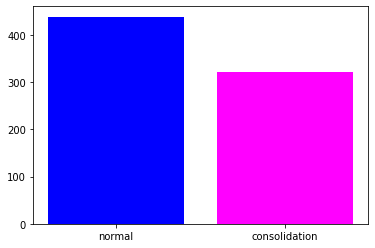

In [11]:
X_train_0_n = len(X_train_0)
X_train_1_n = len(X_train_1)
X_train_plot = X_train_0_n, X_train_1_n

from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import numpy as np

X = ['normal', 'consolidation']

fig, ax = plt.subplots()
plt.bar(X, X_train_plot, color=['blue', 'magenta'])
plt.xticks(X, ('normal', 'consolidation'))
plt.show()

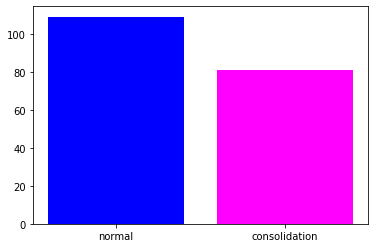

In [12]:
X_test_0_n = len(X_test_0)
X_test_1_n = len(X_test_1)
X_test_plot = X_test_0_n, X_test_1_n

from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import numpy as np

X = ['normal', 'consolidation']

fig, ax = plt.subplots()
plt.bar(X, X_test_plot, color=['blue', 'magenta'])
plt.xticks(X, ('normal', 'consolidation'))
plt.show()

## Paso a grises:

In [13]:
X_train_gris = []
for im in X_train:
    X_train_gris.append(im.convert("L"))
    
    
X_test_gris = []
for im in X_test:
    X_test_gris.append(im.convert("L"))

# Modelos básicos

## Dummy

In [16]:
from sklearn.dummy import DummyClassifier

clf = DummyClassifier(strategy='prior')
clf.fit(X=X_train_gris, y=y_train)
print('Score del clasificador Dummy en test:', clf.score(X=X_test_gris,y=y_test))
# Nota: DummyClassifier en realidad no usa X

Score del clasificador Dummy en test: 0.5736842105263158


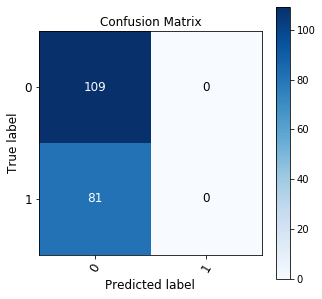

In [17]:
from scikitplot.metrics import plot_confusion_matrix # pip install scikit-plot
plot_confusion_matrix(y_test, clf.predict(X_test_gris),
                      x_tick_rotation=60, figsize=(5,5),
                      text_fontsize='large');

## Regresión Logística

### Primero "aplano" las imágenes:

In [18]:
new_size = (100,100)

imagenes_tr_resized = np.array([np.array(im.resize(new_size)) for im in X_train_gris]) / 255
imagenes_te_resized = np.array([np.array(im.resize(new_size)) for im in X_test_gris]) / 255

imagenes_tr_resized.shape, imagenes_te_resized.shape

((760, 100, 100), (190, 100, 100))

In [19]:
imagenes_tr_flat = imagenes_tr_resized.reshape(len(imagenes_tr_resized), -1)
imagenes_te_flat = imagenes_te_resized.reshape(len(imagenes_te_resized), -1)

imagenes_tr_flat.shape, imagenes_te_flat.shape

((760, 10000), (190, 10000))

In [20]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(X=imagenes_tr_flat, y=y_train)
print('Score de la regresión logística en test:', clf.score(X=imagenes_te_flat,y=y_test))

/home/isua/anaconda3/envs/CAPRI/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Score de la regresión logística en test: 0.5473684210526316


In [21]:
y_te_pred = clf.predict(imagenes_te_flat)

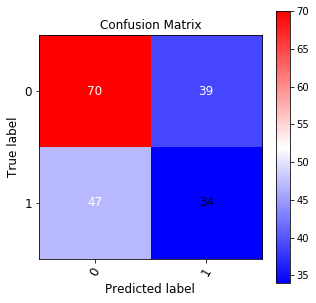

In [22]:
plot_confusion_matrix(y_test, y_te_pred, cmap="bwr",
                      x_tick_rotation=60, figsize=(5,5),
                      text_fontsize='large');

In [23]:
from sklearn.metrics import classification_report, roc_curve, auc

def report(y_num, y_pred, y_prob_pred):
    print('')
    print(classification_report(y_num, y_pred))

    fpr, tpr, thresholds = roc_curve(y_num, y_prob_pred)
    fig, ax1 = plt.subplots(1,1)
    ax1.plot(fpr, tpr, 'r-.', label = 'Simple model (%2.2f)' % auc(fpr, tpr))
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.plot(fpr, fpr, 'b-', label = 'Random Guess')
    ax1.legend();

In [24]:
clf.classes_

array([0, 1])


              precision    recall  f1-score   support

           0       0.60      0.64      0.62       109
           1       0.47      0.42      0.44        81

    accuracy                           0.55       190
   macro avg       0.53      0.53      0.53       190
weighted avg       0.54      0.55      0.54       190



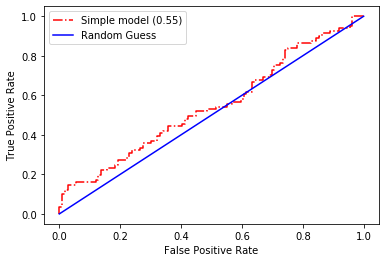

In [25]:
report(y_test, y_te_pred,
            clf.predict_proba(imagenes_te_flat)[:,1])

# CNN

In [26]:
from keras.models import Sequential, load_model, Model
from keras.layers import (Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation,
                          BatchNormalization)
from keras import backend as K
from keras import regularizers
from keras.losses import binary_crossentropy
from keras import optimizers
from keras.callbacks import ModelCheckpoint

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [27]:
new_size = (64,64)

aux_tr = np.array([np.array(im.resize(new_size)) for im in X_train_gris])
aux_te = np.array([np.array(im.resize(new_size)) for im in X_test_gris])

aux_tr.shape, aux_te.shape

((760, 64, 64), (190, 64, 64))

In [28]:
imgs_tr_resized2 = np.array([np.expand_dims(np.array(im),2) for im in aux_tr]) / 255
imgs_te_resized2 = np.array([np.expand_dims(np.array(im),2) for im in aux_te]) / 255

In [29]:
imgs_tr_resized2.max()

1.0

In [30]:
imgs_tr_resized2[0].shape

(64, 64, 1)

In [31]:
norm_images_tr = []

for image in imgs_tr_resized2:
    norm_image = np.divide(image, image.mean())
    norm_images_tr.append(norm_image)
    
    
norm_images_te = []

for image in imgs_te_resized2:
    norm_image = np.divide(image, image.mean())
    norm_images_te.append(norm_image)

In [32]:
imgs_tr_resized2 = np.array(norm_images_tr)
imgs_te_resized2 = np.array(norm_images_te)

In [33]:
def mi_montage2d(data):
    n = len(data)
    lado = int(np.ceil(np.sqrt(n)))
    alto1, ancho1 = data.shape[1:]
    aux = np.zeros((lado*alto1, lado*ancho1))
    for i,image in enumerate(data):
        row = i // lado
        col = i % lado
        aux[(row*alto1):((row+1)*alto1), (col*ancho1):((col+1)*ancho1)] = image
    return aux

def draw_borders(ax, ntiles, tile_width, tile_height, color='r'):
    
    aux1 = int(np.ceil(np.sqrt(ntiles)))
    
    npixels_y = tile_height*aux1
    for i in range(aux1-1):
        aux2 = (i+1)*tile_width - 0.5
        ax.plot([aux2, aux2], [0, npixels_y - 1], color, linewidth=3)
        
    npixels_x = tile_width*aux1
    for i in range(aux1-1):
        aux2 = (i+1)*tile_height - 0.5
        ax.plot([0, npixels_x - 1], [aux2, aux2], color)

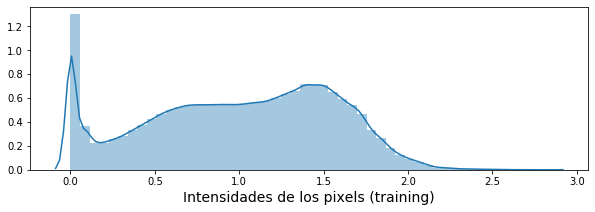

In [34]:
plt.figure(figsize=(10,3))
sns.distplot(imgs_tr_resized2.reshape(-1), bins=50, hist=True, kde=True)
plt.xlabel('Intensidades de los pixels (training)', fontsize=14);

In [36]:
from matplotlib.ticker import MaxNLocator

def grafica_entrenamiento(tr_acc=[], val_acc=[], tr_loss=[], val_loss=[], best_epoch=0,
                          figsize=(10,4)):
    plt.figure(figsize=figsize)
    if len(val_acc)>0:
        ax = plt.subplot(1,2,1)
        plt.plot(1+np.arange(len(tr_acc)),  100*np.array(tr_acc))
        plt.plot(1+np.arange(len(val_acc)), 100*np.array(val_acc))
        plt.plot(1+best_epoch, 100*val_acc[best_epoch], 'or')
        plt.title('tasa de acierto del modelo (%)', fontsize=18)
        plt.ylabel('tasa de acierto (%)', fontsize=18)
        plt.xlabel('época', fontsize=18)
        plt.legend(['entrenamiento', 'validación'], loc='upper left')
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax = plt.subplot(1,2,2)
    else:
        ax = plt.subplot(1,1,1)
    
    plt.plot(1+np.arange(len(tr_loss)), np.array(tr_loss))
    plt.plot(1+np.arange(len(val_loss)), np.array(val_loss))
    plt.plot(1+best_epoch, val_loss[best_epoch], 'or')
    plt.title('loss del modelo', fontsize=18)
    plt.ylabel('loss', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

## Arquitectura del modelo

In [37]:
imgs_tr_resized2.shape

(760, 64, 64, 1)

In [38]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(64, 64, 1)))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Flatten())
model.add(Dense(activation = 'relu', units = 128))
model.add(Dense(activation = 'sigmoid', units = 1))

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

W1116 00:44:31.219440 140254063683392 deprecation_wrapper.py:119] From /home/isua/anaconda3/envs/CAPRI/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1116 00:44:31.394069 140254063683392 deprecation_wrapper.py:119] From /home/isua/anaconda3/envs/CAPRI/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1116 00:44:31.400537 140254063683392 deprecation_wrapper.py:119] From /home/isua/anaconda3/envs/CAPRI/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1116 00:44:31.485521 140254063683392 deprecation_wrapper.py:119] From /home/isua/anaconda3/envs/CAPRI/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please us

In [39]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               802944    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total para

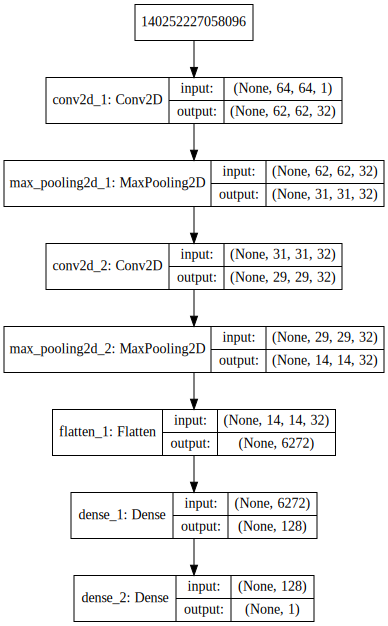

In [40]:
# graphviz
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

Como la red tiene dos neuronas de salida, el target tendrá que tener dos componentes. 

**Clase 0:** las componentes son [1, 0]. **Clase 1:** las componentes son [0, 1]:

In [41]:
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

In [42]:
#y_tr2 = np.hstack((1-y_train.reshape(-1,1), y_train.reshape(-1,1)))
#y_te2 = np.hstack((1-y_test.reshape(-1,1), y_test.reshape(-1,1)))
#y_tr2.shape, y_te2.shape

In [43]:
from sklearn.model_selection import train_test_split
X_training, X_val, y_training, y_val = train_test_split(imgs_tr_resized2, y_train,
                                                        test_size=0.3, random_state=7)

In [44]:
print(y_training.shape)
print(y_val.shape)

(532,)
(228,)


In [45]:
from IPython.display import clear_output

In [46]:
acum_tr_acc   = []
acum_val_acc  = []
acum_tr_loss  = []
acum_val_loss = []
best_val_acc = -1e50
best_epoch = 0
epoca = 0

epochs = 500

In [47]:
batch_size = 32

train_generator = train_datagen.flow(X_training, y=y_training, batch_size=batch_size)

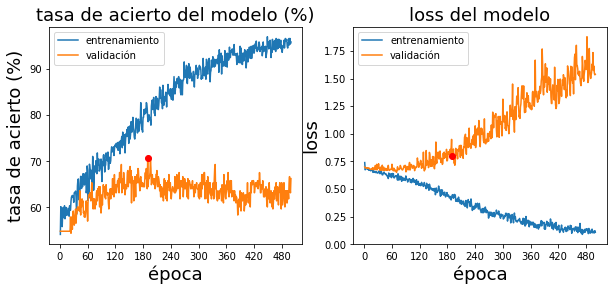

In [48]:
LOAD_MODEL = False

if not LOAD_MODEL:
    filepath="saved_model/manuel_version_pneumonia_kfold10_0.h5"
    
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1,
                                 save_best_only=True,
                                 mode='max') # graba sólo los que mejoran en validación
    callbacks_list = [checkpoint]
    
    for i in range(epochs):
        history = model.fit_generator(train_generator,
                                      steps_per_epoch=int(np.ceil(len(X_training)/batch_size)),
                                      epochs=1,
                                      callbacks=callbacks_list,
                                      verbose=1,
                                      validation_data=(X_val, y_val))
                
        acum_tr_acc.append(history.history['acc'][-1])
        acum_val_acc.append(history.history['val_acc'][-1])
        acum_tr_loss.append(history.history['loss'][-1])
        acum_val_loss.append(history.history['val_loss'][-1])
        
        if len(acum_tr_acc) > 1:
            if acum_val_acc[-1] > best_val_acc:
                best_epoch = epoca
                best_val_acc = acum_val_acc[-1]
            
            clear_output()
            grafica_entrenamiento(acum_tr_acc, acum_val_acc,
                                  acum_tr_loss, acum_val_loss, best_epoch)
        
        epoca = epoca + 1
            
else:
    filepath = "saved_model/manuel_version_pneumonia_kfold10_0.h5"

# Resultados obtenidos por el modelo CNN

In [49]:
model = load_model(filepath)

In [50]:
score_tr = model.evaluate(X_training, y_training, verbose=0)
print('Train loss    :', score_tr[0])
print('Train accuracy:', score_tr[1])

score_val = model.evaluate(X_val, y_val, verbose=0)
print('Val loss    :', score_val[0])
print('Val accuracy:', score_val[1])

score_te = model.evaluate(imgs_te_resized2, y_test, verbose=0)
print('Test loss     :', score_te[0])
print('Test accuracy :', score_te[1])

Train loss    : 0.3912787934891263
Train accuracy: 0.8270676682766219
Val loss    : 0.796568501936762
Val accuracy: 0.706140350877193
Test loss     : 0.7951320736031783
Test accuracy : 0.6263157904148102


In [51]:
def save_result(score_tr, score_val, score_te, version_name):
    
    keys = ["Train loss", "Train accuracy", "Val loss", "Val accuracy", "Test loss", "Test accuracy"]
    values = [score_tr[0], score_tr[1], score_val[0], score_val[1], score_te[0], score_te[1]]
    
    result_dict = {}
    for i in range(len(keys)):
        result_dict[keys[i]] = values[i]
        
    f = open("saved_result/"+version_name+".txt","w")
    f.write( str(result_dict) )
    f.close()

In [52]:
version_name="manuel_version_pneumonia_kfold10_0"
save_result(score_tr, score_val, score_te, version_name)


              precision    recall  f1-score   support

           0       0.64      0.79      0.71       109
           1       0.59      0.41      0.48        81

    accuracy                           0.63       190
   macro avg       0.62      0.60      0.59       190
weighted avg       0.62      0.63      0.61       190



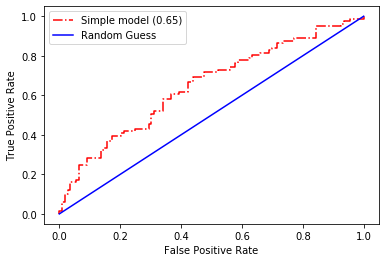

In [53]:
y_te_prob_pred = model.predict(imgs_te_resized2)
y_te_pred = 1*(y_te_prob_pred>0.5)

report(y_test, y_te_pred, y_te_prob_pred)

In [54]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_te_pred)

array([[86, 23],
       [48, 33]])

#### Casos de test con más probabilidad de clase 1 (consolidation):

In [55]:
inds = np.argsort(y_te_prob_pred)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [56]:
y_te_prob_pred = np.array(y_te_prob_pred)

In [58]:
df = pd.DataFrame({"Clase real":y_test})

In [60]:
df.to_csv ('./predicted_labels/manuel_version_pneumonia_kfold10_0.csv', 
           index = None, 
           header=None)